In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
import pyret

In [29]:
device = torch.device('cuda:2')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_65.72_pearson_0.7311.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [30]:
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)
test_pc

0.8112148597583383

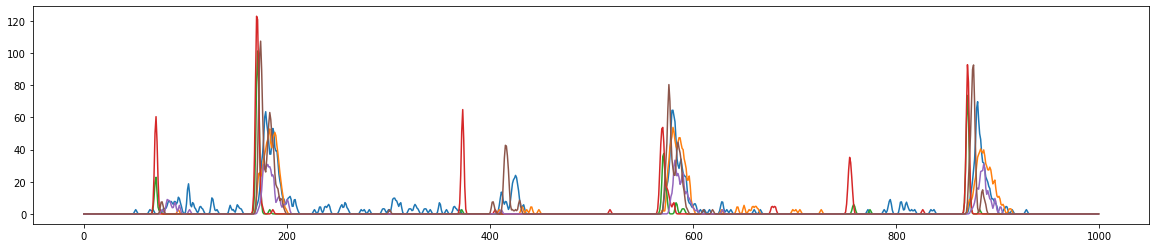

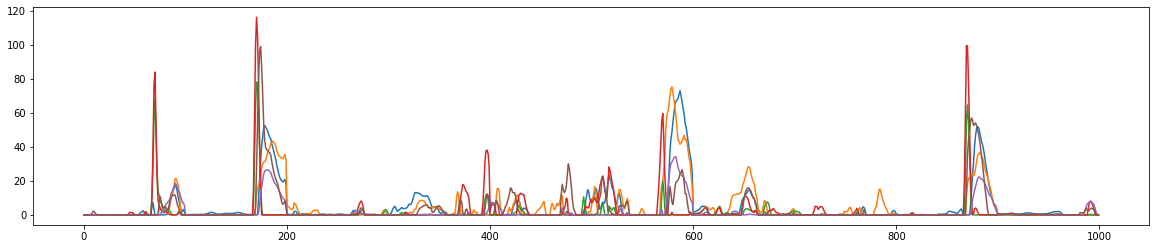

In [31]:
plt.figure(figsize=(20,4))
plt.plot(targ[1000:2000])
plt.show()
plt.figure(figsize=(20,4))
plt.plot(pred[1000:2000])
plt.show()

In [33]:
targ.mean(), pred.mean()

(2.265431030285194, 2.6704338)

In [10]:
with h5py.File('/home/xhding/tem_stim/21-03-15/naturalscene.h5', 'r') as f:
    single_trial_bin = np.array(f['test']['repeats/binned'])
single_trial_bin = np.swapaxes(single_trial_bin,1,2)[:,40:6003,[0,1,2,3,4,6]]
scale_factor = single_trial_bin.mean(axis=1)/single_trial_bin.mean(axis=(0,1))
norm_single_trial_bin = single_trial_bin / np.expand_dims(scale_factor, 1)

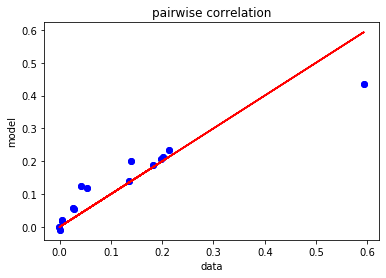

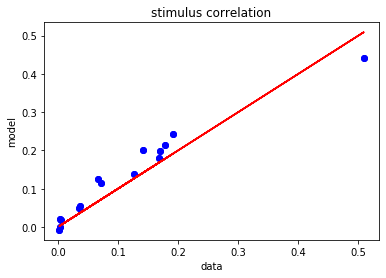

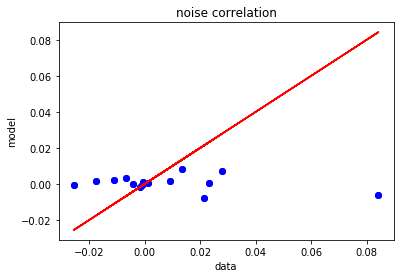

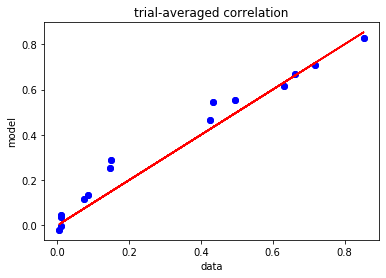

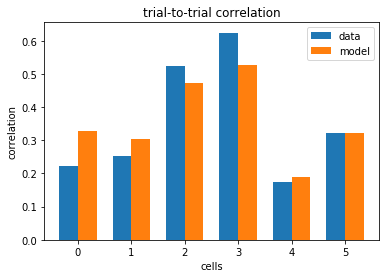

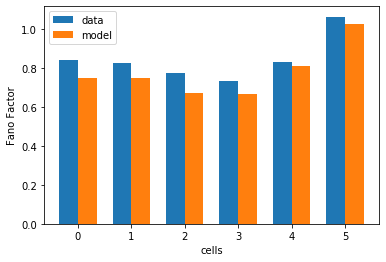

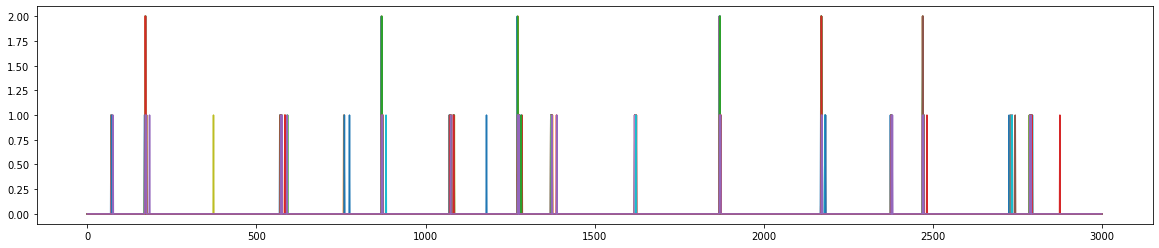

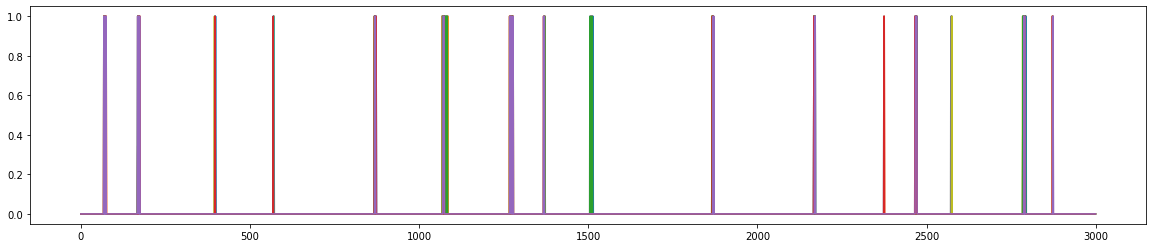

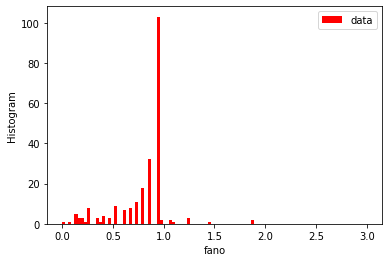

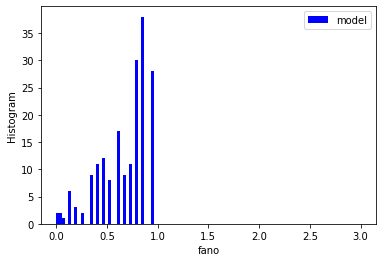

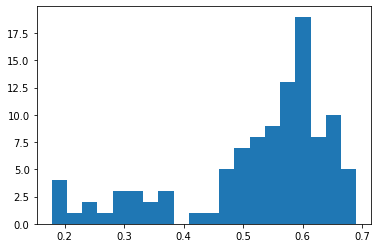

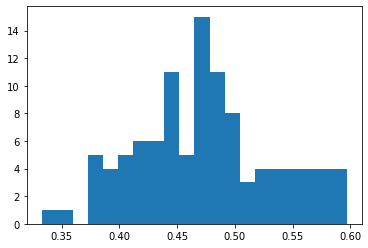

In [41]:
poisson_2s = [0.02, 0.02, 0.023, 0.025, 0.02, 0.0085]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, poisson=[None, None, poisson_2s], gaussian=[0., 0., 0., 0])
pred_single_trial_pre[pred_single_trial_pre<8] = 0.
poisson_rates = (torch.rand(*pred_single_trial_pre.shape).to(device) * 0.1) - 0.05
poisson_rates += 0.01/torch.tensor(poisson_2s).to(device)
poisson_rates = 0.01/poisson_rates
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
#pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)
maxspikes = np.array([1,1,1,1,1,2])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
maxspikes = np.array([2,2,2,2,2,3])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 2
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()

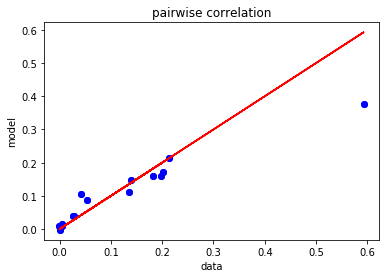

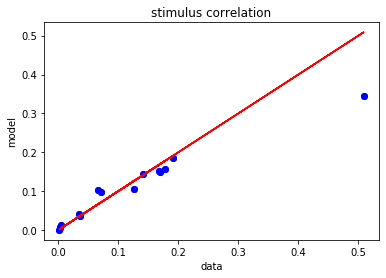

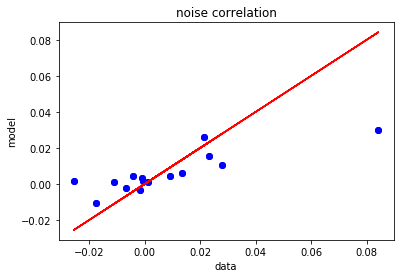

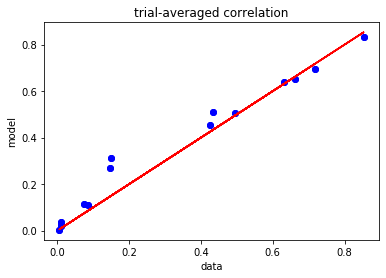

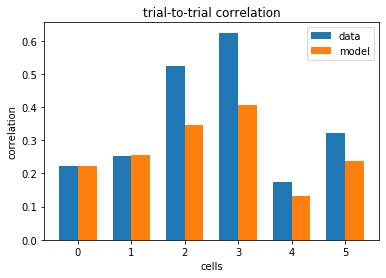

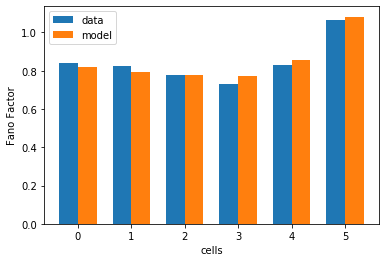

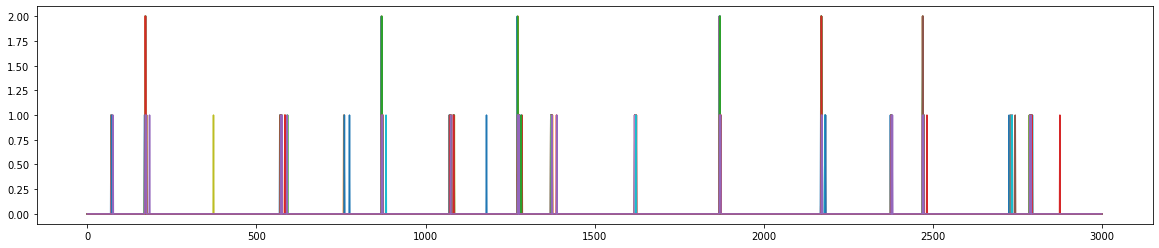

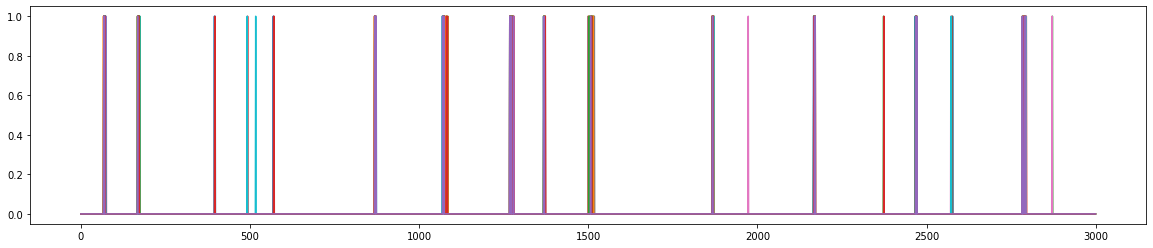

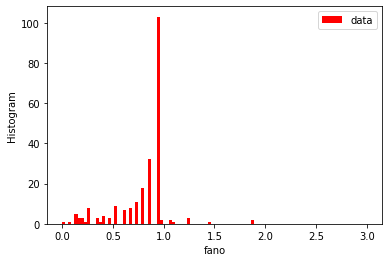

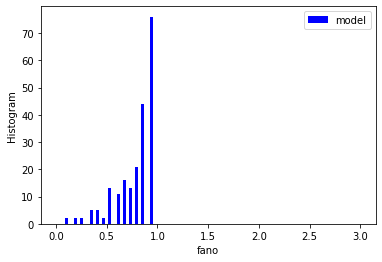

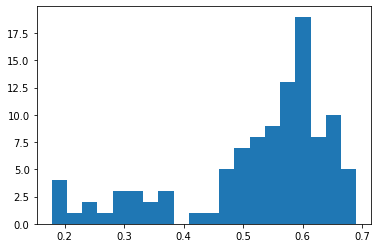

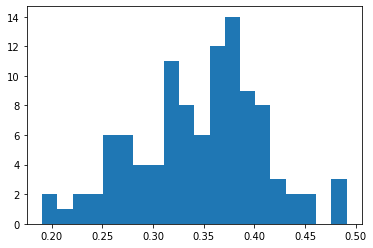

In [46]:
poisson_2s = [0.02, 0.02, 0.045, 0.25, 0.028, 0.0085]
pred_single_trial_pre = model_single_trial_pre(model, test_data, device, n_repeats=15, n_cells=6, poisson=[None, None, poisson_2s], gaussian=[0., 0., 0.25, 0])
pred_single_trial_pre[pred_single_trial_pre<8] = 0.
poisson_rates = (torch.rand(*pred_single_trial_pre.shape).to(device) * 0.1) - 0.05
poisson_rates += 0.01/torch.tensor(poisson_2s).to(device)
poisson_rates = 0.01/poisson_rates
pred_single_trial = torch.poisson(pred_single_trial_pre * poisson_rates) / poisson_rates
pred_single_trial = pred_single_trial.cpu().numpy()
pred_single_trial3 = pred_single_trial.copy()
pred_single_trial3[:, pred<3] = 0.
pred_single_trial3 = pred_single_trial3/100.
pred_single_trial3 = np.floor(np.random.rand(*pred_single_trial3.shape) + pred_single_trial3)
maxspikes = np.array([1,1,1,1,1,2])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra
maxspikes = np.array([2,2,2,2,2,3])
for trial in range(15):
    extra = pred_single_trial3[trial] - maxspikes
    pred_single_trial3[trial] = np.minimum(pred_single_trial3[trial], maxspikes)
    extra[extra<0] = 0
    pred_single_trial3[(trial+1)%15] += extra

correlation_plot(norm_single_trial_bin, pred_single_trial3, 15, 6)
cell = 2
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(single_trial_bin[:,1000:4000,cell], 0, 1))
plt.show()
plt.figure(figsize=(20,4))
plt.plot(np.swapaxes(pred_single_trial3[:,1000:4000,cell], 0, 1))
plt.show()
zero_idx = np.where(single_trial_bin[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(single_trial_bin[:,:,cell].var(0).flatten(), zero_idx)/np.delete(single_trial_bin[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='r', label='data')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
zero_idx = np.where(pred_single_trial3[:,:,cell].mean(0).flatten() == 0)[0]
plt.hist(np.delete(pred_single_trial3[:,:,cell].var(0).flatten(), zero_idx)/np.delete(pred_single_trial3[:,:,cell].mean(0).flatten(), zero_idx), range=(0,3), bins=100, color='b', label='model')
plt.xlabel('fano')
plt.ylabel('Histogram')
plt.legend()
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(norm_single_trial_bin[i,:,cell], norm_single_trial_bin[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()
corrs = []
for i in range(15):
    for j in range(i+1, 15):
        corrs.append(pearsonr(pred_single_trial3[i,:,cell], pred_single_trial3[j,:,cell])[0])
plt.hist(corrs, bins=20)
plt.show()